In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import re
import string
from pyvi import ViTokenizer, ViPosTagger
import nltk
import os

In [3]:
DATA_DIR = '/mnt/d/GoogleDrive/JVN_Courses_Archive/Entropy2018/final/E-E6316_TruongThiThuHa/data/'
negative_path = Path(DATA_DIR + 'Negative_train.csv')
neutral_path = Path(DATA_DIR + 'Neutral_train.csv')
positive_path = Path(DATA_DIR + 'Positive_train.csv')

## 1. Clean data

In [217]:
def check_diff(before_df, after):
    # check
    count = 0
    for index, row in before_df.iterrows():
        if row['text'] != after[index]:
    #         print(row['text'])
    #         print(text[index])
            count += 1
    return count 

from enum import Enum
class Replacement(Enum):

    """Define common constants

    """
    EMOJI_POS = ' EMO_POS_TOKEN '
    EMOJI_NEG = ' EMO_NEG_TOKEN '
    EMAIL = ' EMAIL_TOKEN '
    URL = ' URL_TOKEN '
    NUMBER = ' NUMBER_TOKEN '
    PHONE = ' PHONE_TOKEN '
    CURRENCY = ' CURRENCY_TOKEN '
    DATETIME = ' DATETIME_TOKEN '
    
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', Replacement.EMOJI_POS.value, tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)\s', Replacement.EMOJI_POS.value, tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', Replacement.EMOJI_POS.value, tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', Replacement.EMOJI_POS.value, tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', Replacement.EMOJI_NEG.value, tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', Replacement.EMOJI_NEG.value, tweet)
    
#     tweet = tweet.replace(' EMO_POS ', ' ')
#     tweet = tweet.replace(' EMO_NEG ', ' ')

    return tweet

def handle_url(tweet):
    tweet = re.sub(r'http\S+', Replacement.URL.value, tweet)
    return tweet

def handle_email(text):
    return re.sub(r'(\w+@\w+)', Replacement.EMAIL.value, text)

def handle_numbers(text):
    # normal numbers
    text = re.sub(r'^\d+\s|\s\d+\s|\s\d+$|\b[\d.\/,]+', Replacement.NUMBER.value, text)
    text = re.sub(r'\b[\d.\/,]+', Replacement.NUMBER.value, text)
    return text

def handle_phone(text):
    """
    Handle cases:
        XX XXX XXX
        XXX XXX XXX
        XXXXXXXXX         
    delimiter: whitespace OR - OR empty
    """
    return re.sub(r'([\+\s]*\d{2,}[-\s.]?\d{3,4}[-\s.]?\d{3,4})', Replacement.PHONE.value, text)

# remove money before datetime
def handle_money(text):
    """
    Handle cases:
        Group 1
            1,500 (k |tr |triệu|đồng|đ |USD|vnđ)
            23.456.567(k |tr |triệu|đồng|đ |USD|vnđ)
            60.18
        Group 2
            1.000
            12.000.000
        Group 3
            5tr300
    """
    million_unit = r'triệu|Triệu|TRIỆU|trieu|Trieu|TRIEU'
    billion_unit = r'tỷ|ty|Tỷ|TỶ|tỉ|Tỉ|TỈ'
    usd_unit = r'usd|Usd|USD'
    vnd_unit = r'đồng|Đồng|ĐỒNG|dong|Dong|DONG|vnđ|Vnđ|VNĐ|vnd|Vnd|VND'
    other_unit = r'((k|K|tr|TR|đ|Đ)(\s|\.|-|,|;|:))'
    unit = r'(\s?(' + other_unit + '|' + vnd_unit + '|' + million_unit + '|' + billion_unit + '|' + usd_unit + '))'
    group_1 = r'(\d+([.,]\d{2,})*' + unit + '\d*)'
    group_2 = r'((\d{1,})([.,]0{3})+)'
    group_3 = r'(\d+\s?' + unit +'\s?\d+)'
#     print(r'(' + group_1 + '|'+ group_2 + '|' + group_3 + ')')
    return re.sub(r'(' + group_1 + '|'+ group_2 + '|' + group_3 + ')', Replacement.CURRENCY.value, text)

def handle_datetime(text):
    """
    Handle cases: MM/YYYY, DD/MM/YYYY, DD/MM
    delimiters: /.-
    """
    # MM/YYYY
    group_1 = r'(\d{1,2}[-./]\d{4})'
    
    # DD/MM or DD/MM/YYYY
    group_2 = r'(\d{1,2}[-./]\d{1,2}([-./]\d{4})?)'
    
    # 09h56 OR 12h
    group_3 = r'(\d{1,2}(h|H|g|G|giờ|Giờ)(\d{1,2}(phút|Phút|ph|PH)?)?)'
    return re.sub(r'(' + group_1 + '|' + group_2 + '|' + group_3 + ')', Replacement.DATETIME.value, text)
    
    
def handle_address(text):
    pass

def remove_non_alphabet(tweet):
    """
    Reference: http://vietunicode.sourceforge.net/charset/vietalphabet.html
    """
    tweet = re.sub(
        r'[^aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0-9_' + string.punctuation + ']',
        ' ', tweet
    )
    return tweet

def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\S+)', tweet)
    tweet = re.sub(r'#(\S+)', ' ', tweet)
    return tweet, hashtags

def handle_hashtags(df):
    hashtags = list()
    for index, row in df.iterrows():
        tweet, ht = extract_hashtags(row['text'])
        hashtags.extend(ht)
        df.loc[index, 'text'] = tweet
    return df, hashtags

def find_proper_name_in_fb(text, pattern, direction='both'):
    m = re.search(pattern, text)
    if m is not None:
        start = m.span()[0]
        idx_prev_upper = [start]
        
        # find previous name
        if direction in ['left', 'both']:
            i = start - 1
            while i >= 0:
                i -= 1
                if text[i] in list(string.punctuation):
                    break
                if text[i] == ' ':
                    if str.islower(text[i+1]):
                        break
                    if str.isupper(text[i+1]):
                        idx_prev_upper.append(i+1)
                        if len(idx_prev_upper) >= 5:
                            break
            
        # find after name
        end = m.span()[1]
        idx_next_upper = [end]
        if direction in ['right', 'both']:
            i = end
            nb_capital_words = 0
            while i < (len(text) - 1):
                if text[i] in list(string.punctuation):
                    break
                if text[i] == ' ':
                    if str.islower(text[i + 1]):
                        idx_next_upper.append(i)
                        break
                    if str.isupper(text[i + 1]):
                        idx_next_upper.append(i)
                        nb_capital_words += 1
                        if nb_capital_words > 5:
                            break
                            
                i += 1
                if i == (len(text) - 1):
                    # get the ending position
                    idx_next_upper.append(i)
            
        return idx_prev_upper[-1], idx_next_upper[-1]
    return None, None
            
def handle_facebook_posting(text):
    """
    extract feelings
    remove ending of texts which come from posting photos on Facebook
    """
    feelings = []
    
    # feeling
    feeling_patterns = [(r"(is\s|was\s)?feeling (\w+)(\s?\.)", "left"), 
                        (r"(is\s|was\s)?feeling (\w+)(\swith) (.+?) at", "both"),
                        (r"(is\s|was\s)?feeling (\w+)((\sat|\swith) \w+)", "both"),
                       ]
    for feeling_pattern, direction in feeling_patterns:
        temp_feelings = re.findall(feeling_pattern, str.lower(text))
        if len(temp_feelings) > 0:
            feelings.extend([f[1] for f in temp_feelings])
            
       # remove feelings
        start, end = find_proper_name_in_fb(text, r'(' + feeling_pattern + ')', direction=direction)
        if start is not None and end is not None:
    #         print(start, len(text))
            if (start*1./ len(text)) >= 0.7:
    #             print(start, len(text))
                text = text[:start]
            else:
                text = text.replace(text[start:end], ' ')
    #     print('TEXT', text)
    text = re.sub(r'(and \d+ others)', ' ', text)
            
    # remove pattern posting photos ending
    text = re.sub(r"(Photos from (.+?)'s post)", ' ', text)
    
    # remove added photos/video
    photo_pattern = r'(added (\d+|a) new (photos|photo|videos|video))'
#     print('TEST', text)
    start, end = find_proper_name_in_fb(text, photo_pattern, direction='left')
    if start is not None and end is not None:
#         print('TEST', start, len(text))
        if (start*1./ len(text)) >= 0.7:
#             print('TEST', start, len(text))
            text = text[:start]
        else:
            text = text.replace(text[start:end], ' ')
            
    # remove pattern "check in"
    checkin_patterns = [r'(with (.+?) and (.+?)\.)', r'(and \d+ others at)',  r'(\d+ others at)']
    for checkin_pattern in checkin_patterns:
#         print(text)
        start, end = find_proper_name_in_fb(text, checkin_pattern, direction='both')
        if start is not None and end is not None:
#             print(start, end, text[start:end])
            if (start*1./ len(text)) >= 0.7:
#                 print(start, len(text))
                text = text[:start]
            else:
                text = text.replace(text[start:end], ' ')
    
    # remove share pattern
    share_pattern = r"(shared (.+?)'s (post|photo|photos))"
    start, end = find_proper_name_in_fb(text, share_pattern, direction='left')
    if start is not None and end is not None:
#         print(start, len(text))
        if (start*1./ len(text)) >= 0.7:
#             print(start, len(text))
            text = text[:start]
        else:
            text = text.replace(text[start:end], ' ')
        
    # remove some special words
    text = re.sub(r'(Timeline Photos)', ' ', text)
            
    return text, feelings

def lower_case(text):
    """
    if 70% text is upper case, it might be upper case to take attention of reader
    """
    count_upper = len([w for w in text.split() if w.isupper()])
    if count_upper >= len(text.split()) * 0.5:
        text = str.lower(text)
    return text
            
def preprocess_sentence(text):
    """
    """    
    funcs = [lower_case, handle_emojis, handle_url, handle_phone, 
             handle_money, handle_datetime,  handle_numbers,
             handle_email, remove_non_alphabet, ]
    for f in funcs:
        text = f(text)
    
    return text

def preprocess_document(doc, export_pos=True):

    text, feelings = handle_facebook_posting(doc)
    text, hashtags = extract_hashtags(text)

    # remove 1-character sentence
    sents = [s for s in nltk.sent_tokenize(
        ViTokenizer.tokenize(text)) if len(s) > 1]
    # print('step1: \t', sents)

    # preprocess each sentence
    sents = [preprocess_sentence(s.strip()) for s in sents]
    # print('step2: \t', sents)

    # filter again too short sentence
    sents = [s.strip() for s in sents if len(s.strip()) > 1]
    # print('step3: \t', sents)

    # add punctuation at the end of each sentence if it does not have
    sents = [' '.join([w.strip(string.punctuation + ' ')
                       for w in nltk.word_tokenize(s)]) for s in sents]
    sents = [s if s.endswith(tuple(string.punctuation))
             else s + ' .' for s in sents]
    # print('step4: \t', sents)

    # post tagging. Note that we lower case after doing posttagging in order
    # to make pre step work correctly
    final_sents = []
    for s in sents:
        tokens, labels = ViPosTagger.postagging(s)
        tokens = [t.lower() for t in tokens]
        if export_pos:
            final_sents.append(
                ' '.join(['%s/%s' % (t, l)
                          for t, l in zip(tokens, labels) if len(t) > 0]))
        else:
            final_sents.append(
                ' '.join([t for t in tokens if len(t) > 0]))
    # print('final_sents:', ' '.join(final_sents))
    return ' '.join(final_sents)

In [100]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:
positive_df = pd.read_csv(positive_path, header=None, names=['text'])
negative_df = pd.read_csv(negative_path, header=None, names=['text'])
neutral_df = pd.read_csv(neutral_path, header=None, names=['text'])
print('positive', positive_df.shape)
print('negative', negative_df.shape)

positive (32531, 1)
negative (30800, 1)


In [403]:
# check emoji
processed = positive_df.text.apply(handle_emojis)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

3096/32531


In [404]:
# check url
processed = positive_df.text.apply(handle_url)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

18/32531


In [405]:
# check handle_numbers
processed = positive_df.text.apply(handle_numbers)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

12954/32531


In [406]:
# check handle phone
processed = positive_df.text.apply(handle_phone)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

2218/32531


In [407]:
# check handle money
processed = positive_df.text.apply(handle_money)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

4593/32531


In [408]:
# check handle email
processed = positive_df.text.apply(handle_email)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

186/32531


In [402]:
# check handle datetime
processed = []
for index, row in positive_df.iterrows():
    funcs = [handle_numbers, handle_phone, handle_money,]
    text = row['text']
    for f in funcs:
        text = f(text)
    processed.append(handle_datetime(text))
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

14832/32531


In [243]:
# check FB pattern
pos_feelings = []
processed = []
for index, row in positive_df.iterrows():
    text, feelings = handle_facebook_posting(row['text'])
    pos_feelings.extend(feelings)
    processed.append(text)
    
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

neg_feelings = []
for index, row in negative_df.iterrows():
    text, feelings = handle_facebook_posting(row['text'])
    neg_feelings.extend(feelings)
    processed.append(text)
    
print('%s/%s' % (check_diff(negative_df, processed), negative_df.shape[0]))

neu_feelings = []
for index, row in neutral_df.iterrows():
    text, feelings = handle_facebook_posting(row['text'])
    neu_feelings.extend(feelings)
    processed.append(text)
    
print('%s/%s' % (check_diff(neutral_df, processed), neutral_df.shape[0]))

2117/32531
30800/30800
39334/39334


In [246]:
set(pos_feelings)

{'accomplished',
 'alone',
 'amused',
 'annoyed',
 'awesome',
 'blessed',
 'comfortable',
 'confident',
 'confused',
 'crazy',
 'cute',
 'emotional',
 'energized',
 'excited',
 'fabulous',
 'fantastic',
 'funny',
 'glad',
 'great',
 'happy',
 'homesick',
 'hopeful',
 'hot',
 'hottttttttt',
 'hungry',
 'hyper',
 'inspired',
 'joyful',
 'loved',
 'lovely',
 'missing',
 'motivated',
 'nice',
 'nostalgic',
 'ok',
 'peaceful',
 'positive',
 'proud',
 'pumped',
 'relaxed',
 'sad',
 'satisfied',
 'stuck',
 'surprised',
 'thankful',
 'thèm',
 'tired',
 'warm',
 'wonderful'}

In [245]:
set(neg_feelings)

{'afraid',
 'amused',
 'angry',
 'annoyed',
 'anxious',
 'bad',
 'chill',
 'confused',
 'cool',
 'crazy',
 'curious',
 'cute',
 'depressed',
 'desperate',
 'disappointed',
 'dizzy',
 'drained',
 'emotional',
 'enraged',
 'excited',
 'glad',
 'hot',
 'hãm',
 'irritated',
 'lame',
 'lost',
 'lovely',
 'mad',
 'ok',
 'pained',
 'pissed',
 'proud',
 'sad',
 'scared',
 'shocked',
 'silly',
 'sleepy',
 'sore',
 'sorry',
 'spooky',
 'terrible',
 'tired',
 'tởm',
 'unhappy',
 'upset',
 'useless',
 'wonderful',
 'worried',
 'yucky',
 'điên'}

In [244]:
set(neu_feelings)

{'alone',
 'amazed',
 'amazing',
 'amused',
 'angry',
 'annoyed',
 'awesome',
 'beautiful',
 'blessed',
 'blue',
 'cold',
 'comfortable',
 'confused',
 'cool',
 'crazy',
 'cute',
 'disappointed',
 'dizzy',
 'drained',
 'emotional',
 'energized',
 'excited',
 'exhausted',
 'fantastic',
 'fortunate',
 'glad',
 'great',
 'happy',
 'heartbroken',
 'homesick',
 'hopeful',
 'hot',
 'hungry',
 'hyper',
 'impatient',
 'incomplete',
 'joyful',
 'lame',
 'lost',
 'loved',
 'lovely',
 'meh',
 'motivated',
 'naughty',
 'ngon',
 'ok',
 'peaceful',
 'phê',
 'proud',
 'pumped',
 'quởn',
 'refreshed',
 'relaxed',
 'sad',
 'satisfied',
 'sick',
 'sleepy',
 'stuffed',
 'surprised',
 'thankful',
 'tired',
 'unhappy',
 'wonderful',
 'worried'}

In [ ]:
# find Proper name
feeling_pattern = r"(is\s|was\s)?feeling (\w+)(\s?\.|((\sat|\swith) \w+))"
# text = 'vk ơi! vk hãy cố lên vk nha! yêu vk nhiều lắm . Thanh Ke feeling happy. with Thanh Trầm at Bệnh Viện Phụ Sản Nhi Bình Dương.'
for index, row in positive_df.iterrows():
    text = row['text']
    b, e = find_proper_name_in_fb(text, feeling_pattern)
    if b is not None and e is not None:
        print('%s\nBEFORE:\n%s' % (text[b:e], text))
        text, feeling = handle_facebook_posting(text)
        print('AFTER:\n%s\n' % text)
    

In [198]:
# text = " Chưa hết: Khách hàng thanh toán Phí bảo hiểm online giảm thêm 10% Chi tiết xin liên hệ : TVV Nguyễn Hương Giang  Hotline: 0973.607.034  #Manulife #sảnphẩmcôngnghệsố Tatoo Disappear added 2 new photos — feeling excited with Thúy Đỗ and 7 others at Manulife - CMC Tower. Photos from Tatoo Disappear's post"
# photo_pattern = r'(added (\d+|a) new (photos|photo|videos|video))'
# print(text)
# print(handle_facebook_posting(text))

In [ ]:
for index, row in negative_df.iterrows():
    text = row['text']
    b, e = find_proper_name_in_fb(text, feeling_pattern)
    if b is not None and e is not None:
        print(b, e)
        print('%s\n%s' % (text[b:e], text))
        text, _ = handle_facebook_posting(text)
        print('AFTER:\n%s\n' % text)

In [ ]:
for index, row in neutral_df.iterrows():
    text = row['text']
    b, e = find_proper_name_in_fb(text, feeling_pattern)
    if b is not None and e is not None:
#         print(b, e)
        print('%s\n%s' % (text[b:e], text))
        text, _ = handle_facebook_posting(text)
        print('AFTER:\n%s\n' % text)

In [ ]:
 text = re.sub(r"(Photos from (.+?)'s post)", ' ', text)

In [410]:
# check handle_hashtags
hashtags = []
processed = []
for index, row in positive_df.iterrows():
    text, h = extract_hashtags(row['text'])
    processed.append(text)
    hashtags.extend(h)
    
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))
print('total of hashtags: ', len(hashtags))
print('total of distinct hashtags:', len(set([str.lower(h) for h in hashtags])))

7284/32531
total of hashtags:  17017
total of distinct hashtags: 3534


In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hatruong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [411]:
# check handle lower case
processed = positive_df.text.apply(lower_case)
print('%s/%s' % (check_diff(positive_df, processed), positive_df.shape[0]))

250/32531


In [412]:
# Review before apply
count = 0
for index, row in positive_df.iterrows():
    text = handle_datetime(row['text'])
    if text != row['text']:
        print(text)
        print(row['text'])
        count += 1
        if count == 100:
            beak

JETSTAR KM CUỐI TUẦN SÀI GÒN - HẢI PHÒNG BAY TỪ  DATETIME_TOKEN  ĐẾN  DATETIME_TOKEN  GIÁ 1350K SÀI GÒN - THANH HOÁ BAY TỪ  DATETIME_TOKEN  ĐẾN  DATETIME_TOKEN  GIÁ 1350K SÀI GÒN - VINH BAY TỪ  DATETIME_TOKEN  ĐẾN  DATETIME_TOKEN  GIÁ 1350K ( GIÁ KHỨ HỒI ĐÃ BAO GỒM THUẾ PHÍ ) Liên hê:01205916908
JETSTAR KM CUỐI TUẦN SÀI GÒN - HẢI PHÒNG BAY TỪ 20.8 ĐẾN 31/10 GIÁ 1350K SÀI GÒN - THANH HOÁ BAY TỪ 20.8 ĐẾN 31/10 GIÁ 1350K SÀI GÒN - VINH BAY TỪ 20.8 ĐẾN 31/10 GIÁ 1350K ( GIÁ KHỨ HỒI ĐÃ BAO GỒM THUẾ PHÍ ) Liên hê:01205916908
Jeststar Pacific Khuyến Mãi CHÀO MỪNG 2 ĐƯỜNG BAY MỚI: HÀ NỘI - OSAKA & ĐÀ NẴNG – OSAKA giá chỉ  DATETIME_TOKEN  DATETIME_TOKEN 0 đồng  Nhân dịp này, Jetstar Pacific còn ưu đãi GIẢM GIÁ NHIỀU ĐƯỜNG BAY - giá chỉ từ  DATETIME_TOKEN 0 đồng  Chương trình chỉ diễn ra duy nhất trong 3 ngày : từ 11:00 ngày  DATETIME_TOKEN  đến 23:59 ngày  DATETIME_TOKEN   Nhanh tay truy cập:   để book vé và chờ ngày du ngoạn thành phố sương mù Osaka thôi!  Thông báo cho cả nhà là 2 đường bay n

NameError: name 'beak' is not defined

In [ ]:
positive_df.text[27]

In [ ]:
processed[27]

In [468]:
neutral_df = pd.read_csv(neutral_path, header=None, names=['text'])
neutral_df.shape

(39334, 1)

In [475]:
preprocess_sentence('VE RE CUNG JETSTAR: Vinh - Ho Chi Minh. 21,22,23,24/2 giá 199k, (chưa thuế và phí) / 1 chiều! Bạn nào cần alo ngay ak  LH: 0961.408.535 ')

'VE RE CUNG JETSTAR: Vinh - Ho Chi Minh. 21,22,23, DATETIME_TOKEN  giá  CURRENCY_TOKEN  (chưa thuế và phí) / NUMBER_TOKEN chiều! Bạn nào cần alo ngay ak  LH: PHONE_TOKEN  '

### Tokenizer

In [ ]:
# A - Adjective
# C - Coordinating conjunction
# E - Preposition
# I - Interjection
# L - Determiner
# M - Numeral
# N - Common noun
# Nc - Noun Classifier
# Ny - Noun abbreviation
# Np - Proper noun
# Nu - Unit noun
# P - Pronoun
# R - Adverb
# S - Subordinating conjunction
# T - Auxiliary, modal words
# V - Verb
# X - Unknown
# F - Filtered out (punctuation)

SENTIMENT_POS = ['A', 'R']
OTHER_POS = ['X', 'C', 'S', 'T']
other_tokens = dict()
for pos in OTHER_POS:
    other_tokens[pos] = []
count = 0
for index, row in positive_df.iterrows():
    # handle facebook posting & hashtags first because tokenize process will modify the original text
    # hence pattern will not match anymore
    text, feelings = handle_facebook_posting(row['text'])
    text, hashtags = extract_hashtags(text)
    
    # remove 1-character sentence 
    sents =[s for s in nltk.sent_tokenize(ViTokenizer.tokenize(text)) if len(s) > 1]
#     print('step1: \t', sents)
    
    # preprocess each sentence
    sents = [preprocess_sentence(s.strip()) for s in sents]
#     print('step2: \t', sents)
    
    # filter again too short sentence
    sents = [s.strip() for s in sents if len(s.strip()) > 1]
#     print('step3: \t', sents)

    # add punctuation at the end of each sentence if it does not have
    sents = [' '.join([w.strip(string.punctuation + ' ') for w in nltk.word_tokenize(s)]) for s in sents]
    sents = [s if s.endswith(tuple(string.punctuation)) else s + ' .' for s in sents]
    print('step4: \t', sents)
    
    # post tagging
    final_sents = []
    for s in sents:
        tokens, labels = ViPosTagger.postagging(s)
        tokens = [t.lower() for t in tokens]
        final_sents.append(' '.join(['%s/%s' % (t, l) for t, l in zip(tokens, labels) if len(t) > 0]))
    print('final_sents:', ' '.join(final_sents))
            
#         for pos in OTHER_POS:
#             other_tokens[pos].extend([t for t, l in zip(tokens, labels) if l == pos])
#         has_sentiment_words = False
#         for l in labels:
#             if l in SENTIMENT_POS:
#                 has_sentiment_words = True
#                 break
#         if has_sentiment_words:
#             print(['(%s, %s)' % (t, l) for t, l in zip(tokens, labels) if len(t) > 0])
   
    if index == 100:
        break

for pos in OTHER_POS:
    print(pos, set(other_tokens[pos]))

In [382]:
from tqdm import tqdm
tqdm.pandas()
DATA_DIR = '/mnt/d/MyGit/sentiment-analysis/data/'
def preprocess():
    file_names = ['Negative_train.csv',
                  'Neutral_train.csv',
                  'Positive_train.csv']
    for fname in file_names:
        path = Path(DATA_DIR + fname)
        df = pd.read_csv(path, header=None, names=['text'])
#         logger.info('start preprocess file: %s', fname)
        df.text = df.text.progress_apply(preprocess_document)
        df.to_csv(path + '.tokenize', index=False, header=False)
#         logger.info('done preprocess file: %s', fname)


text cause error when calling ViTokenizer.tokenize

In [415]:
# 5500078b-2863-4374-94c0-eb109f792e0f KOTEX Thuy Duong NguyenĐã đến lúc chúng ta khôn lớn
# Vinaphone PLUS - CHƯƠNG TRÌNH ƯU ĐÃI ĐÍCH THỰC
t = 'Uyen TranPhong cách'
path = Path(DATA_DIR + 'Neutral_train.csv')
df = pd.read_csv(path, header=None, names=['text'])
for index, row in df.iterrows():
    if row['text'].find(t) >= 0:
        print(index)

17717


In [416]:
text = df.text[17717].strip(string.punctuation + ' ')
sents =[s for s in nltk.sent_tokenize(ViTokenizer.tokenize(text)) if len(s) > 1]
sents = [preprocess_sentence(s.strip(string.punctuation + ' ')) for s in sents]
# sents = [ViTokenizer.tokenize(s) for s in sents]
sents

['8181af39 - a9e0 - NUMBER_TOKEN - be9f - 091d43f4df6f Uyen TranPhong cách']

### Detect language
accent restore if vietnames

In [436]:
# detect language
from langdetect import detect_langs
from collections import Counter
file_names = [
        'Negative_train.csv',
        'Neutral_train.csv',
        'Positive_train.csv']
for fname in file_names:
    path = Path(DATA_DIR + fname)
    df = pd.read_csv(path, header=None, names=['text'])
    languages = []
    for index, row in df.iterrows():
        text = preprocess_document(row['text'].strip(string.punctuation + ' '), export_pos=False)
        if len(text) > 1:
            try:
                res = detect_langs(text)
                if len(res) > 0:
                    languages.append(res[0].lang)
            except:
                print(row['text'])
                raise Exception('aaa')
    print(fname, Counter(languages))
# Negative_train.csv Counter({'vi': 29878, 'tl': 260, 'en': 126, 'id': 94, 'pt': 79, 'it': 79, 'so': 45, 'sw': 35, 'es': 28, 'nl': 26, 'cy': 20, 'fr': 19, 'ca': 16, 'af': 13, 'hr': 12, 'ro': 12, 'fi': 10, 'de': 9, 'sk': 7, 'sl': 7, 'hu': 6, 'sq': 5, 'cs': 3, 'tr': 3, 'da': 2, 'lt': 1, 'th': 1, 'no': 1, 'pl': 1, 'lv': 1})
# Neutral_train.csv Counter({'vi': 37872, 'en': 647, 'tl': 213, 'pt': 106, 'id': 100, 'it': 41, 'fr': 34, 'es': 31, 'hr': 29, 'cy': 29, 'so': 25, 'sw': 24, 'ro': 23, 'ca': 23, 'de': 21, 'sk': 18, 'nl': 15, 'sq': 15, 'fi': 12, 'hu': 10, 'et': 8, 'af': 7, 'lt': 6, 'sv': 5, 'no': 4, 'sl': 4, 'pl': 4, 'da': 3, 'cs': 1, 'tr': 1, 'zh-cn': 1, 'ja': 1, 'lv': 1})    

Positive_train.csv Counter({'vi': 32123, 'en': 178, 'pt': 23, 'tl': 22, 'id': 20, 'sk': 20, 'da': 15, 'nl': 14, 'so': 13, 'sv': 10, 'sq': 10, 'it': 9, 'ca': 9, 'cy': 8, 'fr': 7, 'no': 7, 'fi': 7, 'ro': 7, 'hu': 4, 'es': 4, 'af': 4, 'sw': 3, 'et': 2, 'sl': 2, 'lv': 2, 'hr': 1, 'cs': 1})


## 2. Analyze Term Frequency

In [351]:
# length of documents, extract document contains less than 3 words
import string
from gensim.models import KeyedVectors
wv_model = KeyedVectors.load_word2vec_format('../model/sentiment_sg.vec')
DATA_DIR = '../data/'
corpus_paths = [ 
    Path(DATA_DIR + 'Negative_train.csv.preprocessed.train'),
    Path(DATA_DIR + 'Neutral_train.csv.preprocessed.train'),
    Path(DATA_DIR + 'Positive_train.csv.preprocessed.train')]

short_documents = dict()
punct = list(string.punctuation)
term_not_in_w2v = dict()
doc_lengths = dict()
words_per_label = dict()
for corpus_path in corpus_paths:
    label = os.path.basename(str(corpus_path)).split('.')[0]
    short_documents[label] = list()
    doc_lengths[label] = list()
    words_per_label[label] = list()
    df = pd.read_csv(corpus_path, header=None, names=['text'])
    for index, row in df.iterrows():
        terms = row['text'].split()
        terms = [t for t in terms if t not in punct]
        doc_lengths[label].append(len(terms))
        if len(terms) > 200:
            words_per_label[label].extend(terms[:200])
        else:
            words_per_label[label].extend(terms)
        for t in terms:
            if t not in wv_model.vocab:
                if t not in term_not_in_w2v:
                    term_not_in_w2v[t] = [len(terms)]
                else:
                    term_not_in_w2v[t].append(len(terms))
        if len(terms) <= 1:
            short_documents[label].append(row['text'])           

In [324]:
import seaborn as sns
import numpy as np
sns.set()
for k, lengths in doc_lengths.items():
    print('label: %s, total documents: %s' % (k, len(lengths)))
    print('min: %s, max: %s, 50-th: %s, 75-th: %s, 90-th: %s, >300: %s' % (
        min(lengths), max(lengths), np.percentile(lengths, 50), np.percentile(lengths, 75),
        np.percentile(lengths, 90), len([l for l in lengths if l >300])))
#     ax = sns.distplot(lengths)

label: Positive_train, total documents: 22874
min: 1, max: 2711, 50-th: 28.0, 75-th: 63.0, 90-th: 102.0, >300: 343
label: Negative_train, total documents: 21528
min: 1, max: 4822, 50-th: 26.0, 75-th: 73.0, 90-th: 277.2999999999993, >300: 2063
label: Neutral_train, total documents: 27687
min: 1, max: 156, 50-th: 20.0, 75-th: 39.0, 90-th: 61.0, >300: 0


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


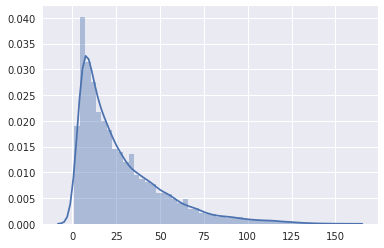

In [318]:
ax = sns.distplot(doc_lengths['Neutral_train'])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


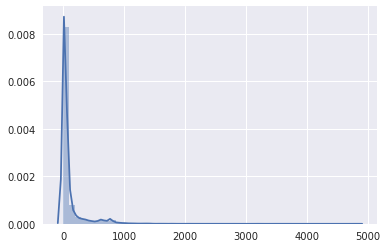

In [319]:
ax = sns.distplot(doc_lengths['Negative_train'])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


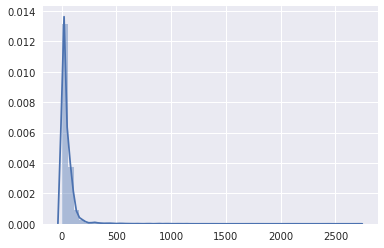

In [320]:
ax = sns.distplot(doc_lengths['Positive_train'])

In [25]:
len(term_not_in_w2v)

78851

In [354]:
count = 0
for t in term_not_in_w2v.keys():
    if np.min(term_not_in_w2v[t]) <=4:
        print(t, term_not_in_w2v[t])
        count += 1

châu_châu [2]
phạm_koi [4]
hoàng_trung_quân [4]
trinh_huỳnh [2]
đang_võ [3]
k_cz [4]
fudelồn [1]
hakuryuu_chan_tú [3]
thái_phước_huy [3]
tấm_tú_mập [4]
hùng_anh [4]
hằng_vũ [2]
tôn_thị_diễm_trinh [4]
phan_hai [3, 7]
võ_thấy [3]
việt_ánh [4]
bùi_thu_thảo [3]
wua_di [2]
ximmy_kang [4]
trần_thử [4]
boong_bynk [4]
yêu_binnnn [3]
cong_ty_bao [4, 13]
nhật_feeling [3]
minh_duy_ha [3]
chệ_thanh_remy [3]
nha_ck [4]
zuôi [4]
nguyễn_ngọc_hồ_thanh_kiềukiều [4]
nguyễn_hòa_đọc [2]
thích_dáng [3]
đithôi [4]
thanh_tu [2]
nhuu [4]
ellyna [4]
viet_nga [3]
kinh_tom [1]
đôi_kìa [4]
hoàng_thị_trang [4]
ngọc_ánhnguyễn [4]
đỗ_huệ [3]
duong_minh_kha [4]
đốt_sạch [1]
mà_vô [4]
dcm_masan [1]
lương_kém [4]
dxc [4]
vũ_lý [4]
trân_la_phúc [3]
mit_xu [4]
đoàn_thảo_mai [4]
cô_khỉ_nhỏ [3]
yuki_huynh [3]
cm_k [2]
huệ_nghi [4]
thien_trangm [2]
phạm_tuyết_trinh [3]
phước_chúc [4]
ghe_thu [3]
hú_c [4]
nguyễn_thuy_nguyen [2]
vong_vẩn [1]
nguyễn_được [4]
duong_dương [3]
nạo_kênh [1]
nguyễn_kim_yếnnini [3]
duyên_thùy_lẹ [4]

In [355]:
# Length <=4
# Positive_train 1267
# Negative_train 2016
# Neutral_train 2309

# Length <=3
# Positive_train 556
# Negative_train 1341
# Neutral_train 990

# Length <= 2
# Positive_train 188
# Negative_train 706
# Neutral_train 376

# Length <= 1
# Positive_train 188
# Negative_train 706
# Neutral_train 376
print(short_documents['Negative_train'])

['tẩy_chay .', 'gớm_ry .', 'gớm_thê .', 'đắt_nhể .', 'nhục_nhã .', 'ghê_v .', 'al_hiro .', 'eo_ây .', 'xấu .', 'ghê_nhở .', 'ghe .', 'chết_thật .', 'ac_độc .', 'hoạn_thư .', 'nguy_hiểm_thật .', 'giet_het .', 'tệ_vc .', 'bắn_hết .', 'kinh_vcc .', 'lam_quỳnh .', 'xau_te .', 'luẩn_quẩn .', 'kinh_vãi .', 'lừa_dao .', 'hỏng_oy .', 'ghớm_hè .', 'sợ .', 'tẩy_chaythooi .', 'vãi .', 'hoàng_quỳnh_anh .', 'so_wa .', 'phạm_văn_ninh .', 'dat_qua .', 'nhe .', 'fuden_sề .', 'tao_lso .', 'hài_thật .', 'hoang_mang .', 'xấu .', 'kinh_vcl .', 'du_ma_tởm .', 'hãi .', 'nạo_kênh .', 'bà .', 'điêu_vồn .', 'ghe_wa .', 'ghê_vl .', 'đốt_sạch .', 'k_sợ .', 'nhuc .', 'fudelồn .', 'ghê_thế .', 'lua_dao .', 'hoang_mang .', 'thua .', 'xấu_òm .', 'tonhokodeubencaobenthap .', 'cùi .', 'rồi .', 'khiếp_vãi .', 'chán_nhỉ .', 'chết .', 'kinh_vch .', 'đắt_lòi .', 'khiếp_sợ .', 'có_đĩa .', 'ui_hại .', 'xau_thiet .', 'quá_bẩn .', 'lôi_kéo .', 'bỉm_jo .', 'ọe .', 'trí_châu .', 'ghê .', 'đụ_mẹ .', 'park_nu .', 'hoang_mang .', 

In [356]:
print(short_documents['Positive_train'])

['nhanh .', 'techcombank_nha .', 'hâhha .', 'hoyy .', 'yêu .', 'techcom_ah .', 'ngon_lành .', 'hon .', 'ngon_thiệt .', 'number1 .', 'number1 .', 'yêu_techcombank .', 'xuất_sắc .', 'ok_vợ .', 'chuẩn_techcombank .', 'thành_công .', 'pru_di .', 'chi_tiết .', 'fan_milo .', 'hóng .', 'hay .', 'techcom_hehee .', 'chuẩn .', 'đê .', 'oke .', 'ổn .', 'hahahaha .', 'iu_lam .', 'đẹp .', 'ổn .', 'biểu_cảm .', 'tks_sacombank .', 'nguyễn_thu_huyền_mát .', 'hay .', 'hay_qua .']


In [357]:
# print('common words between pos & neg', set())
words_per_label.keys()
import itertools
for x in list(itertools.combinations(words_per_label.keys(), 2)):
    a = set(words_per_label[x[0]])
    b = set(words_per_label[x[1]])
    common = a.intersection(b)
    print('common words between %s(%s) & %s(%s):' % (x[0], len(a), x[1], len(b)))
    print('\t%s (%.2f%% in %s and %.2f%% percent in %s)\n' % (
        len(common), len(common) * 100./len(a), x[0], len(common) * 100./len(b), x[1]))

common words between Positive_train(31813) & Negative_train(34305):
	13253 (41.66% in Positive_train and 38.63% percent in Negative_train)

common words between Positive_train(31813) & Neutral_train(37208):
	14419 (45.32% in Positive_train and 38.75% percent in Neutral_train)

common words between Negative_train(34305) & Neutral_train(37208):
	13051 (38.04% in Negative_train and 35.08% percent in Neutral_train)



In [358]:
for x in list(itertools.combinations(words_per_label.keys(), 2)):
    a = set(words_per_label[x[0]])
    b = set(words_per_label[x[1]])
    common = a.intersection(b)
    print('common words between %s(%s) & %s(%s):' % (x[0], len(a), x[1], len(b)))
    print('\t%s\n' % common)

common words between Positive_train(31813) & Negative_train(34305):
	{'vừng', 'trọng_điểm', 'twitter', 'tít', 'đường_ống', 'cắc', 'hang_nguyen', 'lông', 'cup', 'kz', 'điều_ước', 'có_thánh', 'only', 'xác_minh', 'trên_cơ_sở', 'nao_cung', 'pc', 'tiếp_thị', 'thiếu_sót', 'học', 'gặp_mặt', 'ngược_xuôi', 'cod', 'tiếng_nói', 'lượm_lặt', 'tiêu_hủy', 'cao_giá', 'ký_tên', 'size', 'ngành', 'khử', 'khau', 'tháng_này', 'chuyên_viên', 'con_số', 'tí', 'nhất_thiết', 'trug', 'thực_thi', 'hằn', 'house', 's8plus', 'hạn_hẹp', 'sữa_th', 'kèo', 'nghiêm_trọng', 'được_lòng', 'luộc', 'thưa', 'đối_xử', 'chích', 'watch', 'phản_lực', 'winer', 'trng', 'kkkkk', 'nát', 'nhóc', 'tổ_chức', 'meries', 'đg', 'đuọc', 'địu', 'xảy', 'ci', 'bầu_kiên', 'ca_dao', 'vài', 'nhân_thọ', 'vie', 'nhất_là', 'tiêu_biểu', 'ar', 'mun', 'hầy', 'gjo', 'phó_chủ_nhiệm', 'qũy', 'imess', 'nách', 'đây_đây', 'honda', 'chuyên_mục', 'lệ_phí', 'cãi', 'nói_thẳng', 'giáo_viên', 'tập_tành', 'phan_thi', 'may_ra', 'rối_rít', 'thac', 'tra_tấn', 'bọc', 'bự

In [ ]:
# list of words for each POS
# list of common words for each POS ammong 3 labels

## 3. Analyze Word embedding result

In [1]:
from gensim.models import KeyedVectors

In [2]:
wv_model = KeyedVectors.load_word2vec_format('../model/skipgram_min_count_5.vec')
# wv_ex_model = KeyedVectors.load_word2vec_format('../model/sentiment_external_sg.vec')

In [236]:
len(wv_model.vocab)

82274

In [53]:
for w in wv_model.vocab:
    print(w)
    break
# wv_model.vocab

khó_khăn


In [249]:
if 'khó_khăn' in wv_model.vocab:
    print('aa')

aa


In [4]:
wv_model.most_similar('mp3', topn=10)

[('zing', 0.688727855682373),
 ('sáng_tác', 0.663419246673584),
 ('onlyc', 0.6387360095977783),
 ('nhạc', 0.5356882810592651),
 ('girl', 0.5244176387786865),
 ('let', 0.47600090503692627),
 ('bống_bống_bang', 0.46038538217544556),
 ('tự_vấn', 0.45484551787376404),
 ('nghe', 0.45416373014450073),
 ('hey', 0.43445515632629395)]

### 3.1 Visualize words with t-SNE

In [47]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '..')
from src import viz_helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
wv_model = KeyedVectors.loviz_helper.ad_word2vec_format('../model/sentiment_sg.vec')
viz_helper.tsne_plot(wv_model, '../output/tsne_word2vec.html')

### 3.2 Visualize words with MDS

In [45]:
wv_model = KeyedVectors.load_word2vec_format('../model/sentiment_sg.vec')

In [50]:
# viz_helper.mds_plot(wv_model, '../output/mds_sentiment_sg.html', nb_words=100)

In [252]:
DATA_DIR = '../data/'
corpus_paths = [ 
    Path(DATA_DIR + 'Negative_train.csv.preprocessed'),
    Path(DATA_DIR + 'Neutral_train.csv.preprocessed'),
    Path(DATA_DIR + 'Positive_train.csv.preprocessed')]

# for corpus_path in corpus_paths:
#     df = pd.read_csv(corpus_path, header=None, names=['text'])

### 3.3 Visualize with WordCloud

In [304]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

STOPWORDS=['email_token', 'url_token', 'number_token', 'phone_token', 'currency_token', 'datetime_token']

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def viz_tf_by_wordcloud(path):
    plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    
    # Read the whole text.
    text = open(path).read()

    # Generate a word cloud image
    wc = WordCloud(max_words=200, width=1000, height=1000, stopwords=STOPWORDS).generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3), aspect='auto', interpolation='bilinear')
    plt.axis("off")

#     # lower max_font_size
#     wordcloud = WordCloud(max_font_size=40).generate(text)
#     plt.figure()
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
# #     plt.show()
    plt.savefig(os.path.basename(path) + '.png')

In [291]:
DATA_DIR = '../data/'
corpus_paths = [ 
    Path(DATA_DIR + 'Negative_train.csv.preprocessed.train'),
    Path(DATA_DIR + 'Neutral_train.csv.preprocessed.train'),
    Path(DATA_DIR + 'Positive_train.csv.preprocessed.train')]

../data/Negative_train.csv.preprocessed.train
../data/Neutral_train.csv.preprocessed.train
../data/Positive_train.csv.preprocessed.train


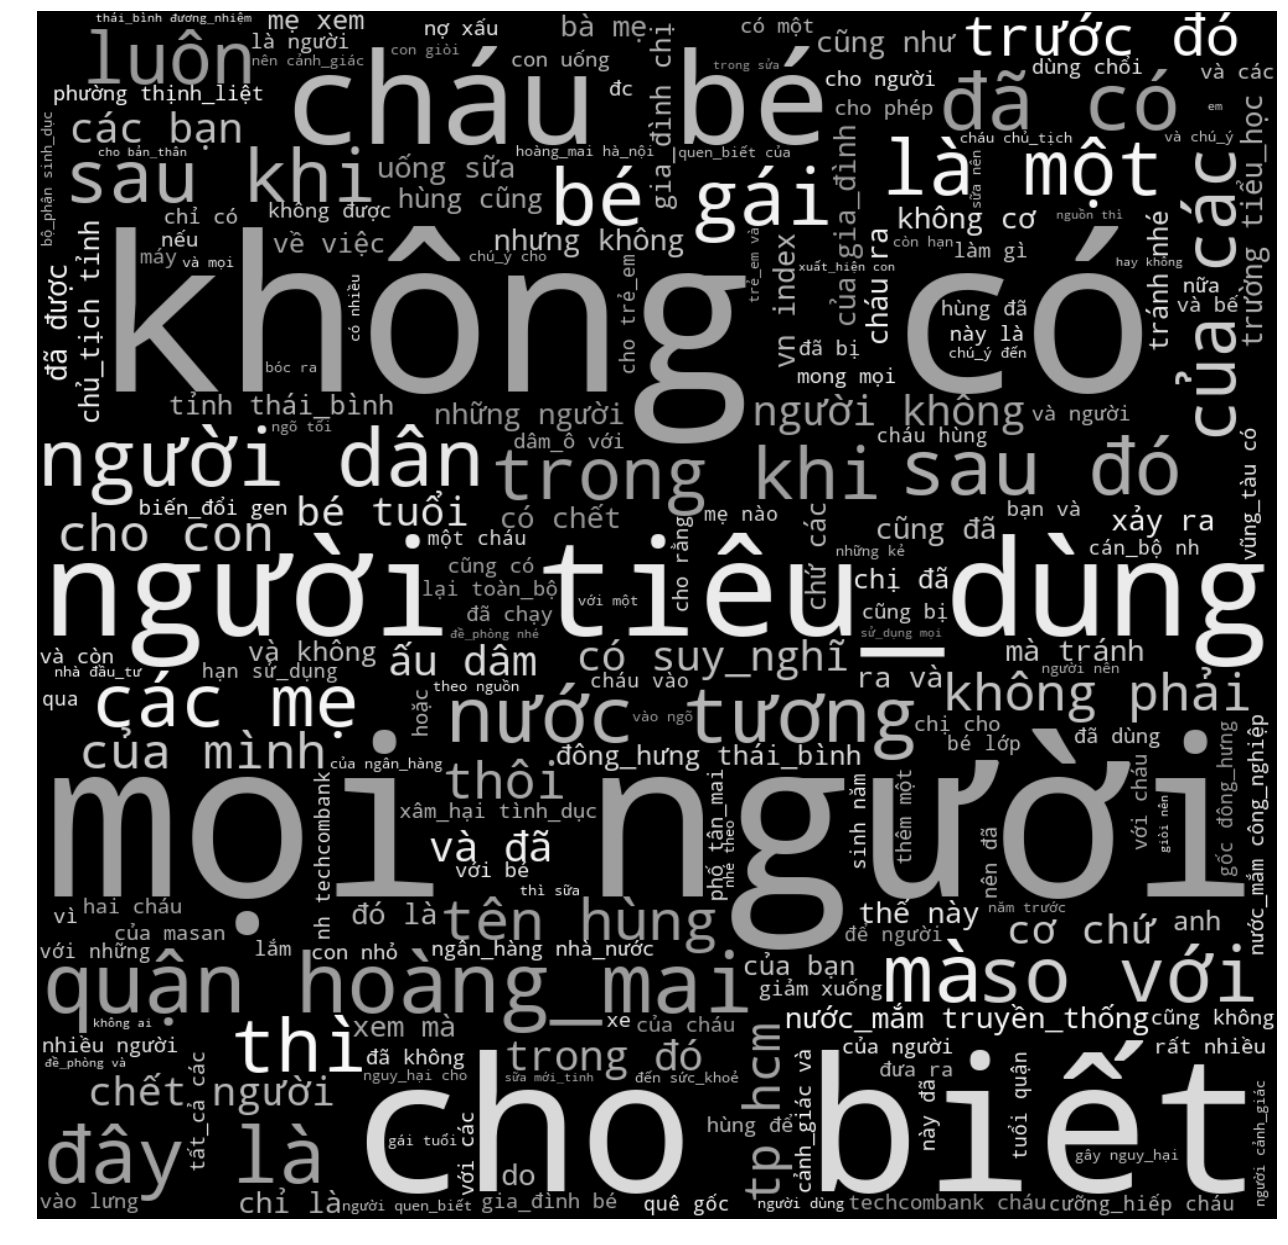

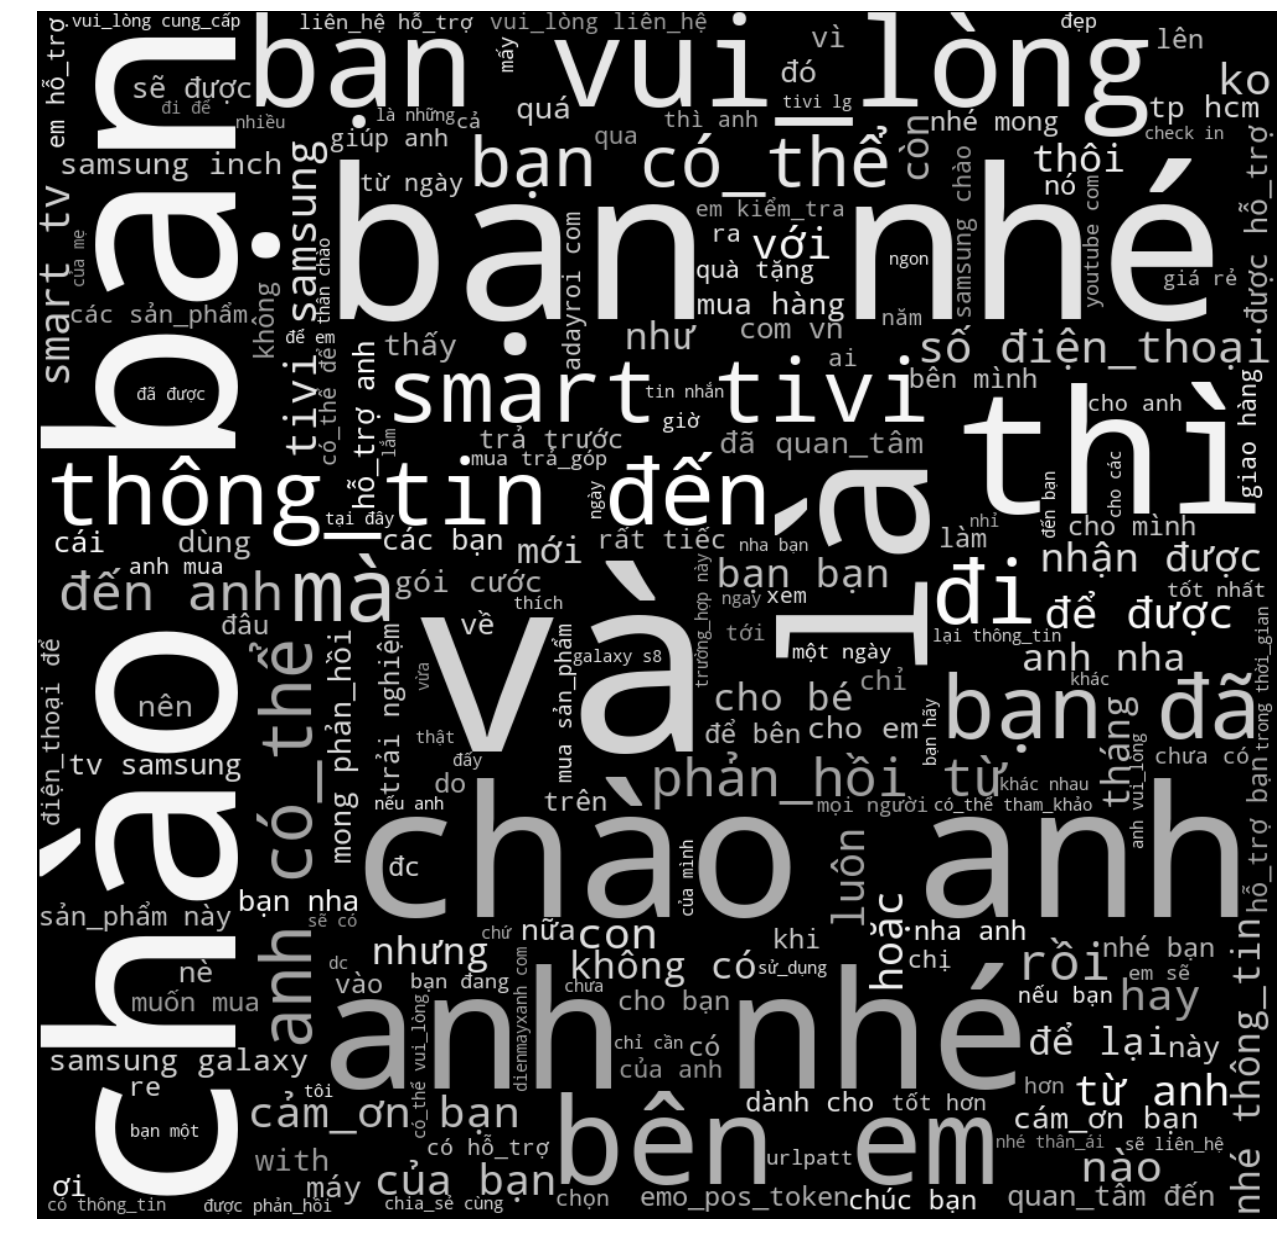

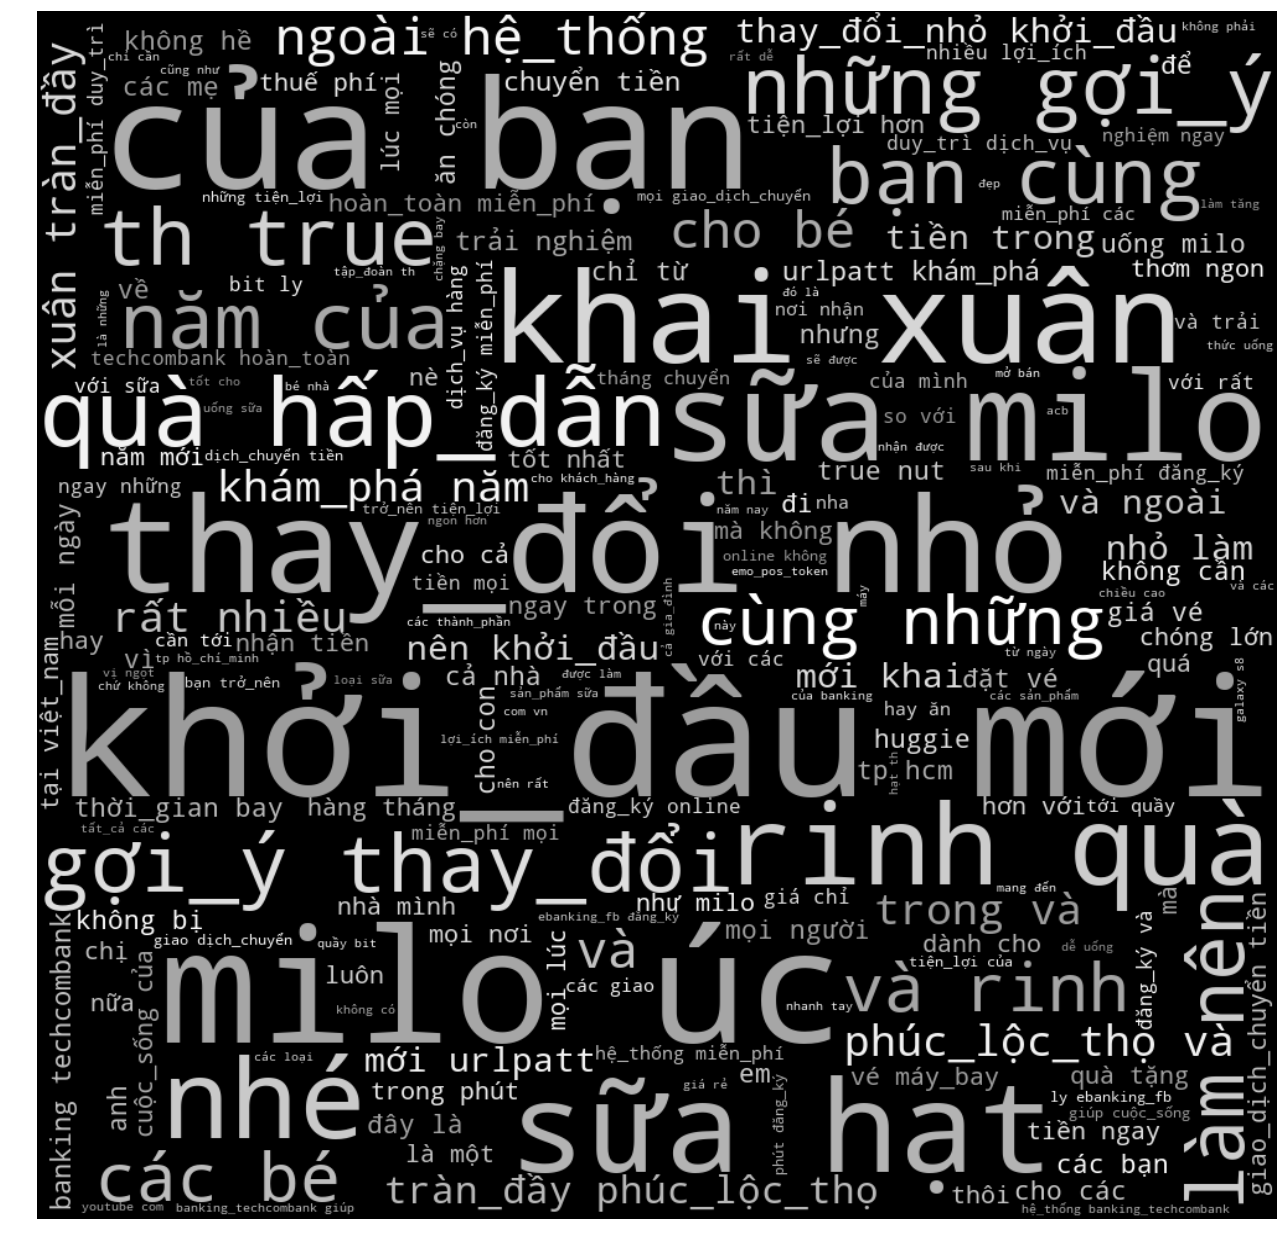

In [305]:
for path in corpus_paths:
    print(str(path))
    viz_tf_by_wordcloud(str(path))

In [380]:
# load VN stopwords
stopword_path = Path(DATA_DIR + 'vietnamese-stopwords-dash.txt')
stopwords = []
with open(str(stopword_path)) as f:
    lines = f.readlines()
    stopwords = [l.strip() for l in lines]
# stopwords[:10]
ignored_words = list(nphrases) + stopwords + list(string.punctuation) + ['email_token', 'url_token', 'number_token', 
                                                        'phone_token', 'currency_token', 'datetime_token']


In [381]:
import gensim
dictionary = gensim.corpora.Dictionary.load('../model/sentiment_min_count_5.dict')
id2word = gensim.utils.revdict(dictionary.token2id)
tfidf_model = gensim.models.TfidfModel.load('../model/tfidf_min_count_5.model')

tfidf_model.idfs.keys()
word2idf = dict()
for k, idf in tfidf_model.idfs.items():
    if id2word[k] not in ignored_words:
        word2idf[id2word[k]] = idf * -1.0

In [383]:
print(len(word2idf))
print(len(tfidf_model.idfs.keys()))

8439
16993


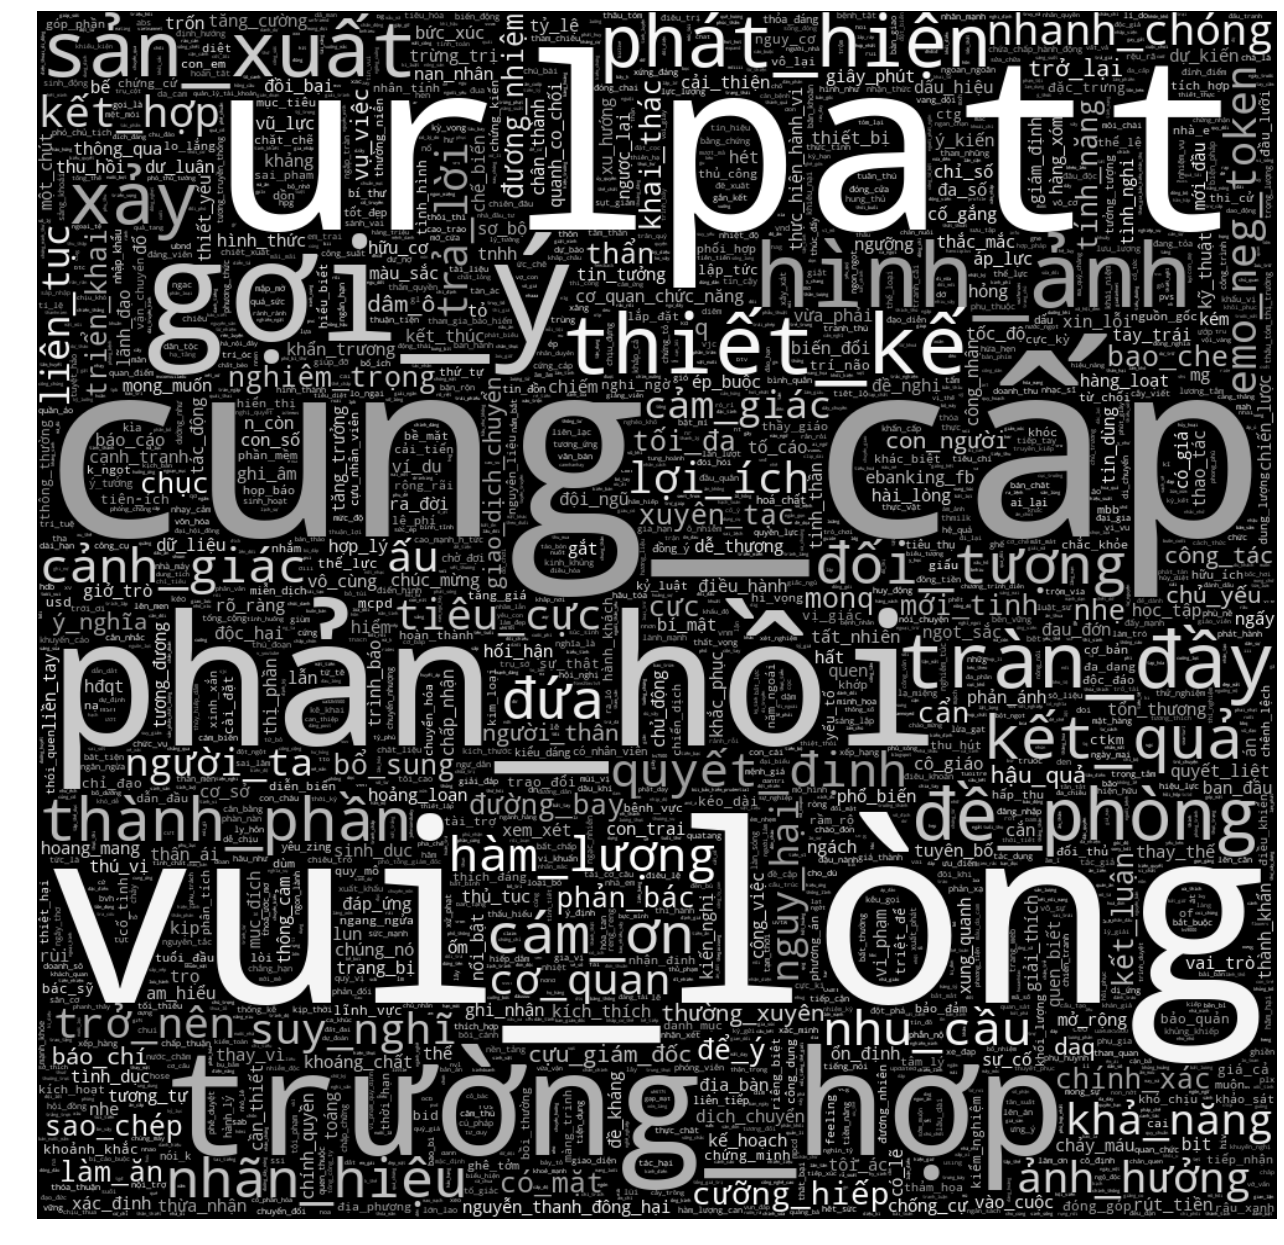

In [384]:
plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

# Generate a word cloud image
wc = WordCloud(max_words=8000, width=1000, height=1000, stopwords=STOPWORDS).fit_words(word2idf)

# Display the generated image:
# the matplotlib way:
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3), aspect='auto', interpolation='bilinear')
plt.axis("off")

plt.savefig('tfidf_wordcloud.png')

In [ ]:
for path in corpus_paths:
    print(str(path))
    viz_idf_by_wordcloud(str(path))

### Analyze POS

In [2]:
DATA_DIR = '../data/'
corpus_paths = [ 
    Path(DATA_DIR + 'Negative_train.csv.preprocessed_pos'),
    Path(DATA_DIR + 'Neutral_train.csv.preprocessed_pos'),
    Path(DATA_DIR + 'Positive_train.csv.preprocessed_pos')]

In [4]:
adj_adv_per_label = dict()
types = ['A', 'R']
nphrases = list()
punct = list(string.punctuation)
for corpus_path in corpus_paths:
    label = os.path.basename(str(corpus_path)).split('.')[0]
    df = pd.read_csv(corpus_path, header=None, names=['text'])
    adj_adv_per_label[label] = list()
    for index, row in df.iterrows():
        terms = row['text'].split()
        if len(terms) > 200:
            terms = terms[:200]
        
        nphrases.extend([t.split('/')[0] for t in terms if t.split('/')[1] == 'Np'])
        terms = [t.split('/')[0] for t in terms if t.split('/')[1] in types]
        terms = [t for t in terms if t not in punct]
        adj_adv_per_label[label].extend(terms)
nphrases = set(nphrases)

In [5]:
print(len(nphrases))

35885


In [377]:
nphrases

{'việt_nam_chubb',
 'sugoi',
 'yahama',
 'nướng_than',
 'ohlins',
 'twitter',
 'shop_top',
 'máy_reano',
 'hang_nguyen',
 'lông',
 'sg_nguyen',
 'kz',
 'lan_moc',
 'only',
 'lương_thị_ngọc_giàu',
 'nguyễn_nhật',
 'yến_huỳnh',
 'đặng_hoa',
 'now_i',
 'lily_ng',
 'châu_châu',
 'ngành',
 'khử',
 'alaska',
 'xài_data',
 'chuyên_viên',
 'tô_vi_vi',
 'đỗ_thắng_hải',
 'khởi_my',
 'anime',
 'house',
 'sữa_th',
 'khánh_khuẩn',
 'nhat_minh_nguyen',
 'bà_huyện',
 'linh_spa',
 'rỉ_pin',
 'mỹ_tâm',
 'winer',
 'nhóc',
 'tbn',
 'duyen_nguyen',
 'liễu_văn',
 'quyên_đỗ',
 'wells_fargo',
 'gjo',
 'phung_huong',
 'minhb',
 'sunsilk_nourishing',
 'ăn',
 'services_awards',
 'nguyen_thảo',
 'hoàng_trung_quân',
 'sỉius',
 'huỳnh_an_thiên',
 'trâm_nelly',
 'người_hùng',
 'diễm_trinh',
 'hfg',
 'bích_thảo',
 'trần_thị_hương',
 'lotteria_maximark',
 'strobel',
 'ascorbyl_glucoside',
 'con_đồ',
 'nỗi',
 'masage',
 'refresh',
 'the_bell',
 'trinh_hoàn',
 'fair_use',
 'hyundai_accent',
 'hình',
 'spa',
 'phú_vocal

In [6]:
# print('common words between pos & neg', set())
adj_adv_per_label.keys()
import itertools
for x in list(itertools.combinations(adj_adv_per_label.keys(), 2)):
    a = set(adj_adv_per_label[x[0]])
    b = set(adj_adv_per_label[x[1]])
    common = a.intersection(b)
    print('common words between %s(%s) & %s(%s):' % (x[0], len(a), x[1], len(b)))
    print('\t%s (%.2f%% in %s and %.2f%% percent in %s)\n' % (
        len(common), len(common) * 100./len(a), x[0], len(common) * 100./len(b), x[1]))

common words between Neutral_train(3692) & Negative_train(5518):
	1963 (53.17% in Neutral_train and 35.57% percent in Negative_train)

common words between Neutral_train(3692) & Positive_train(4350):
	1970 (53.36% in Neutral_train and 45.29% percent in Positive_train)

common words between Negative_train(5518) & Positive_train(4350):
	2153 (39.02% in Negative_train and 49.49% percent in Positive_train)



In [8]:
# print('distinct words between pos & neg', set())
adj_adv_per_label.keys()
import itertools
for x in list(itertools.combinations(adj_adv_per_label.keys(), 2)):
    a = set(adj_adv_per_label[x[0]])
    b = set(adj_adv_per_label[x[1]])
    diff = a.difference(b)
    print('difference words between %s(%s) & %s(%s):' % (x[0], len(a), x[1], len(b)))
    print('\t%s (%.2f%% in %s and %.2f%% percent in %s)\n' % (
        len(diff), len(diff) * 100./len(a), x[0], len(diff) * 100./len(b), x[1]))

difference words between Neutral_train(3692) & Negative_train(5518):
	1729 (46.83% in Neutral_train and 31.33% percent in Negative_train)

difference words between Neutral_train(3692) & Positive_train(4350):
	1722 (46.64% in Neutral_train and 39.59% percent in Positive_train)

difference words between Negative_train(5518) & Positive_train(4350):
	3365 (60.98% in Negative_train and 77.36% percent in Positive_train)



In [11]:
diff_dict = {}
for x in list(itertools.combinations(adj_adv_per_label.keys(), 3)):
    a = set(adj_adv_per_label[x[0]])
    b = set(adj_adv_per_label[x[1]])
    c = set(adj_adv_per_label[x[2]])

    common = a.intersection(b).intersection(c)
    print('common words between %s(%s) & %s(%s) & %s(%s): %s\n' % (x[0], len(a), x[1], len(b), x[2], len(c), len(common)))
    
    diff = a.difference(b).difference(c)
    print('difference words between %s(%s) and (%s(%s) & %s(%s)): %s\n' % (x[0], len(a), x[1], len(b), x[2], len(c), len(diff)))
    diff_dict[x[0]] = diff
    
    diff = b.difference(a).difference(c)
    print('difference words between %s(%s) and (%s(%s) & %s(%s)): %s\n' % (x[1], len(b), x[0], len(a), x[2], len(c), len(diff)))
    diff_dict[x[1]] = diff
    
    diff = c.difference(a).difference(b)
    print('difference words between %s(%s) and (%s(%s) & %s(%s)): %s\n' % (x[2], len(c), x[0], len(a), x[1], len(b), len(diff)))
    diff_dict[x[2]] = diff

common words between Neutral_train(3692) & Negative_train(5518) & Positive_train(4350): 1529

difference words between Neutral_train(3692) and (Negative_train(5518) & Positive_train(4350)): 1288

difference words between Negative_train(5518) and (Neutral_train(3692) & Positive_train(4350)): 2931

difference words between Positive_train(4350) and (Neutral_train(3692) & Negative_train(5518)): 1756



In [12]:
diff_dict['Positive_train']

{'miên_man',
 'zu',
 'cười_duyên',
 'vằng',
 'whey',
 'làlàiềm',
 'fansipan',
 'hài_lọng',
 'khoáng_chất',
 'video_demo',
 'mê_tít',
 'chán_ghét',
 'vựt',
 'bình_an',
 'xơ_xác',
 'đói_meo',
 'nõn_nà',
 'macchiato',
 'đánh_bật',
 'thư_mẹ',
 'choai',
 've_nhe',
 'hot_bạn',
 'mạnh_khỏe_nha',
 'bme',
 'ziên',
 'bố_ích',
 'một_khi',
 'đảm',
 'nan_mát',
 'hayyy',
 'nhỏ_con_con',
 'chuản',
 'phông',
 'úc',
 'nghỉa',
 'nha_hâhha',
 'nghẹo',
 'mới_đó',
 'uki',
 'tương_maggi',
 'nhân_bản',
 'chắc_tay',
 'tối_tăm',
 'kakaa',
 'cua_tech',
 'cơ_thể',
 'phít',
 'ươi',
 'vpbank',
 'chơi_đùa',
 'nhậy_cảm',
 'bạc_hà_cay',
 'uổng',
 'đầy_đặn',
 'rời_rạc',
 'lanh_lợi',
 'đầu_bảng',
 'hoành',
 'lộ_trình',
 'goo',
 'trào_lộng',
 'cắm',
 'gỉ',
 'phân_hủy',
 'đỗ_đẹp',
 'màu',
 'trang_lứa',
 'oành',
 'đương_kim',
 'hoài_vậy',
 'bình_thủy',
 'dữ_dằn',
 'phỏng',
 'gồ_ghề',
 'lịch_lãm',
 'tuất',
 'oki',
 'thỏ',
 'mất_giá',
 'khà_khà',
 'sơ_ý',
 'khoẻ_mạnh',
 'hjhj',
 'nhà_nhà',
 'đụt',
 'thướt_tha',
 'tếch',
 'o

In [13]:
diff_dict['Negative_train']

{'the_day',
 'hỗn',
 'lén_lút',
 'cồn',
 'sộc',
 'dự_bị',
 'sài_xl',
 'kiệt_quệ',
 'sesi',
 'xaj',
 'nếm',
 'dở_hơi',
 'phieu',
 'khệnh_khạng',
 'nghi_ngại',
 'xấu_chăng',
 'nha_c',
 'nhận_dạng',
 'nhừ',
 'lắc_đc',
 'nhịn_đói_òi',
 'bởi_vậy',
 'dè',
 'sầm',
 'khá_khẩm',
 'hanh_ly',
 'băng_thông',
 'nò_kìa',
 'âm_ti',
 'dừ',
 'indo',
 'mẫm',
 'đâubấm',
 'nãn',
 'bỏ_qua',
 'mòn',
 'giã',
 'ts',
 'sản_phẩm_chất_lượng',
 'phiên',
 'môt',
 'luât',
 'hắc',
 'give',
 'toàn_hóa_chất',
 'uyên',
 'mặp',
 'qua_di',
 'nghìn',
 'lệ_phí',
 'recognize',
 'nầy',
 'ga_lăng',
 'e_ah',
 'theo_đuôi',
 'hết_mức',
 'sinh_lợi',
 'tinh_luyện',
 'thừa_mứa',
 'ngàyvẫn',
 'phẫn_nộ',
 'trầm_lắng',
 'lý_ntn',
 'lỏng_lẻo',
 'nhịp_nhàng',
 'giám',
 'hu_hu',
 'xã_giao',
 'giả_dụ',
 'hình_thức',
 'bỏ_mạng',
 'hanoi',
 'chươnb',
 'xa_xăm',
 'ri_nỉ',
 'di_vậy',
 'ghe_qua',
 'dôc',
 'ngư',
 'ton',
 'webosbấm',
 'giao_dịch_chuyển',
 'tu',
 'cao_siêu',
 'dum_a',
 'suy_kiệt',
 'tỷ_lệ',
 'thí_điểm',
 'lymilo',
 'ki_ốt',
 'ng

In [367]:
for x in list(itertools.combinations(adj_adv_per_label.keys(), 2)):
    a = set(adj_adv_per_label[x[0]])
    b = set(adj_adv_per_label[x[1]])
    common = a.intersection(b)
    print('common words between %s(%s) & %s(%s):' % (x[0], len(a), x[1], len(b)))
    print('\t%s\n' % common)

common words between Positive_train(4350) & Negative_train(5518):
	{'xấp_xỉ', 'rò_rỉ', 'cu', 'tít', 'vô_tình', 'minh_họa', 'fullhd', 'mà_ta', 'lân_cận', 'hàng_đầu', 'man', 'ra_hồn', 'khuyen', 'cặm_cụi', 'uy', 'size', 'cỡ', 'h', 'tối', 'chuyển_khoản', 'tí', 'nhất_thiết', 'méo', 'hạn_hẹp', 'đỉnh_cao', 'nhiệt_độ', 'nghiêm_trọng', 'đăng_kí', 'lung_linh', 'thưa', 'êm', 'quý_tộc', 'nhiếu', 'bỗng_nhiên', 'lầy_lội', 'rồ', 'chặt_chẽ', 'nát', 'tôt', 'nhạy', 'sói', 'nhân_thọ', 'kiên_trì', 'còn', 'vđ', 'tit', 'honda', 'cm', 'ngược_lại', 'thuận_lợi', 'nhể', 'lùn', 'bảo_vệ', 'thông_thường', 'đình_đám', 'thời_trang', 'ngẫu_nhiên', 'ha', 'đúng_đắn', 'thảy', 'độc_đáo', 'rõ_ràng', 'lí_do', 'bự', 'im_lặng', 'ư', 'biết_đâu', 'khá', 'mạnh_mẽ', 'mát_rượi', 'sơ_bộ', 'kha_khá', 'may_mắn', 'cũng', 'c_ah', 'thư_giãn', 'viettel', 'ký_tự', 'nhe', 'chất_lượng', 'dũng_cảm', 'kịp', 'tỉnh_táo', 'tất_yếu', 'hài', 'nhật', 'gd', 'quý_giá', 'cảm_tình', 'sệt', 'chứng_khoán', 'vinaphone', 'yếu_kém', 'nc', 'hư', 'mịa', 'vữn

In [27]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score

In [31]:
def count_nonzero(X, axis=None, sample_weight=None):
    """A variant of X.getnnz() with extension to weighting on axis 0
    Useful in efficiently calculating multilabel metrics.
    Parameters
    ----------
    X : CSR sparse matrix, shape = (n_samples, n_labels)
        Input data.
    axis : None, 0 or 1
        The axis on which the data is aggregated.
    sample_weight : array, shape = (n_samples,), optional
        Weight for each row of X.
    """
    if axis == -1:
        axis = 1
    elif axis == -2:
        axis = 0
    elif X.format != 'csr':
        raise TypeError('Expected CSR sparse format, got {0}'.format(X.format))

    # We rely here on the fact that np.diff(Y.indptr) for a CSR
    # will return the number of nonzero entries in each row.
    # A bincount over Y.indices will return the number of nonzeros
    # in each column. See ``csr_matrix.getnnz`` in scipy >= 0.14.
    if axis is None:
        if sample_weight is None:
            return X.nnz
        else:
            return np.dot(np.diff(X.indptr), sample_weight)
    elif axis == 1:
        out = np.diff(X.indptr)
        if sample_weight is None:
            return out
        return out * sample_weight
    elif axis == 0:
        if sample_weight is None:
            return np.bincount(X.indices, minlength=X.shape[1])
        else:
            weights = np.repeat(sample_weight, np.diff(X.indptr))
            return np.bincount(X.indices, minlength=X.shape[1],
                            weights=weights)
    else:
        raise ValueError('Unsupported axis: {0}'.format(axis))


def _check_targets(y_true, y_pred):
    """Check that y_true and y_pred belong to the same classification task
    This converts multiclass or binary types to a common shape, and raises a
    ValueError for a mix of multilabel and multiclass targets, a mix of
    multilabel formats, for the presence of continuous-valued or multioutput
    targets, or for targets of different lengths.
    Column vectors are squeezed to 1d, while multilabel formats are returned
    as CSR sparse label indicators.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    Returns
    -------
    type_true : one of {'multilabel-indicator', 'multiclass', 'binary'}
        The type of the true target data, as output by
        ``utils.multiclass.type_of_target``
    y_true : array or indicator matrix
    y_pred : array or indicator matrix
    """
    # check_consistent_length(y_true, y_pred)
    type_true = type_of_target(y_true)
    type_pred = type_of_target(y_pred)

    y_type = set([type_true, type_pred])
    if y_type == set(["binary", "multiclass"]):
        y_type = set(["multiclass"])

    if len(y_type) > 1:
        raise ValueError("Classification metrics can't handle a mix of {0} "
                         "and {1} targets".format(type_true, type_pred))

    # We can't have more than one value on y_type => The set is no more needed
    y_type = y_type.pop()

    # No metrics support "multiclass-multioutput" format
    if (y_type not in ["binary", "multiclass", "multilabel-indicator"]):
        raise ValueError("{0} is not supported".format(y_type))

    if y_type in ["binary", "multiclass"]:
        y_true = column_or_1d(y_true)
        y_pred = column_or_1d(y_pred)
        if y_type == "binary":
            unique_values = np.union1d(y_true, y_pred)
            if len(unique_values) > 2:
                y_type = "multiclass"

    if y_type.startswith('multilabel'):
        y_true = csr_matrix(y_true)
        y_pred = csr_matrix(y_pred)
        y_type = 'multilabel-indicator'

    return y_type, y_true, y_pred

In [15]:
y_true = np.array([0., 1., 1., 2., 2., 2.])
y_pred = np.array([0., 1., 2., 2., 2., 0.])

In [30]:
y_type, y_true, y_pred = _check_targets(y_true, y_pred)

NameError: name 'check_consistent_length' is not defined

In [33]:
print('%.2f' % accuracy_score(y_true, y_pred))

0.67


In [26]:
differing_labels = count_nonzero(csr_matrix(y_true) - csr_matrix(y_pred), axis=1)
score = differing_labels == 0
np.average(score)

0.0

In [10]:
np.average(y_pred.ravel() == y_true.ravel())

0.6666666666666666

In [11]:
np.mean(y_pred.ravel() == y_true.ravel())

0.6666666666666666